In [394]:
import torch
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

In [396]:
mnist = MNIST("/.",train=True,download=True,transform=ToTensor())

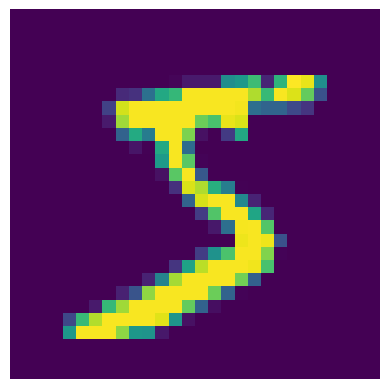

In [398]:
im,label = mnist[0][0].squeeze(),mnist[0][1]
plt.axis('off')
plt.imshow(im)

For a VAE it is common to assume the latent space is a multivaraible gaussian i.e.
$$p_\theta(z) = N(z|0,I)$$
From the original paper we can interpret this as the model that learns $q_{\phi}(z|x)$ which is an approximation to the true posterior $p_\theta(z|x)$. We also assume that this posterior is gaussian with diagonal covariance 
$$\log q_\phi (z|x) = \log N(z| \mu, \sigma^2 I)$$

In [294]:
class Encoder(nn.Module):
    
    def __init__(self,latent_dim=2):
        super(Encoder, self).__init__()
        self.c1 = nn.Conv2d(1,32,3,stride=2)
        self.c2 = nn.Conv2d(32,64,3,stride=2)
        self.flat = nn.Flatten()
        self.l1 = nn.LazyLinear(16)
        self.latent_mu = nn.Linear(16,latent_dim)
        self.latent_log_sigma = nn.Linear(16,latent_dim)
        self.act = nn.ReLU()
    def forward(self,x):
        x = self.act(self.c1(x))
        x = self.act(self.c2(x))
        x = self.flat(x)
        x = self.act(self.l1(x))
        return self.latent_mu(x),self.latent_log_sigma(x)

e = Encoder()
b = torch.cat([mnist[0][0],mnist[1][0]])
b = torch.unsqueeze(b,1)
print(b.shape)
mu,sigma = e(b)
mu,sigma

torch.Size([2, 1, 28, 28])


(tensor([[ 0.0472, -0.0384],
         [ 0.0552, -0.0432]], grad_fn=<AddmmBackward0>),
 tensor([[0.0843, 0.0580],
         [0.0967, 0.0567]], grad_fn=<AddmmBackward0>))

In [296]:
# caluluates the h and widht of the output of conv2d layer

def h(hin,stride,padding,dil,kern,out_pad):
    return (hin-1)*stride-(2*padding)+dil*(kern-1) + out_pad + 1

def w(win,stride,padding,dil,kern,out_pad):
    return (win-1)*stride-(2*padding)+dil*(kern-1) + out_pad + 1

hin,win = 28,28
stride,pad,dil,kern,out_pad = 1,0,1,1,0
h(hin,stride,pad,dil,kern,out_pad),w(win,stride,pad,dil,kern,out_pad)
#2,59

(28, 28)

The decoder learns $p_\theta(x|z)$

In [298]:
class Decoder(nn.Module):
    def __init__(self,latent_dim=2):
        super().__init__()
        self.l1 = nn.Linear(latent_dim,7*7*64)
        self.c1 = nn.ConvTranspose2d(64,64,2,stride=2)
        self.c2 = nn.ConvTranspose2d(64,32,2,stride=2)
        self.c3 = nn.ConvTranspose2d(32,1,1,stride=1)
        self.F,self.S = nn.ReLU(),nn.Sigmoid()

    def forward(self,x):
        x = self.F(self.l1(x))
        x = x.view(-1,64,7,7)
        x = self.F(self.c1(x))
        x = self.F(self.c2(x))
        x = self.S(self.c3(x)) # use sigmoid for last act since image is in 0,1
        return x     
zs = torch.randn(2,2) 
d = Decoder()
dz = d(zs)
print(dz.shape)

torch.Size([2, 1, 28, 28])


In [300]:
class VAE(nn.Module):
    def __init__(self,latent_dim=2):
        super().__init__()
        self.z_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def sample(self,z_mu,z_log_sigma):
        epsilon = torch.randn(self.z_dim)
        return z_mu + torch.exp(0.5 * z_log_sigma) * epsilon
        
    def forward(self,x):
        z_mu,z_log_sigma = self.encoder(x)
        sample_z = self.sample(z_mu,z_log_sigma)
        z = self.decoder(sample_z)
        return z,z_mu,z_log_sigma
        
        

In [302]:
var_auto_encoder = VAE()
x = torch.randn(64,1,28,28)
out,mu,std = var_auto_encoder(x)

In [ ]:
lr = 3e-4
epochs = 30
batch_size = 128
model = VAE()
optim = Adam(model.parameters(),lr=lr)
mnist_dset = DataLoader(mnist,batch_size=batch_size,shuffle=True,drop_last=True)

Since we assume a distribution for $q_\phi(z|x)$ and $p_\theta(z)$ the paper analytically computes the KL divergece
$$KL(q_\phi(z|x)||p_\theta(z)) = \frac{1}{2} \sum_{j=1}^J 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2$$
In general the loss for these models is 
$$-KL(q_\phi(z|x)||p_\theta(z))+\log p_\theta(x|z)$$

In [356]:
def loss_fn(x,reconstructed,z_mu,z_log_sigma):
    mse = nn.BCELoss(reduction='none')
    kl = -0.5*(1. + z_log_sigma  - torch.square(z_mu) - torch.exp(z_log_sigma))
    recon_loss = torch.mean(torch.sum(mse(x,reconstructed),(2,3)))
    return  recon_loss +  torch.mean(torch.sum(kl,axis=1))

In [320]:
x = torch.randn(64,1,28,28)
y = torch.ones(64,1,28,28)
out,mu,sigma = model(x)
loss_fn(out,y,mu,sigma)

tensor(1.0052, grad_fn=<AddBackward0>)

  0%|          | 0/30 [00:00<?, ?it/s]

loss 205.146
loss 181.000


  3%|▎         | 1/30 [00:15<07:22, 15.27s/it]

loss 169.685
loss 169.518


  7%|▋         | 2/30 [00:30<07:05, 15.21s/it]

loss 171.601
loss 164.514


 10%|█         | 3/30 [00:45<06:49, 15.18s/it]

loss 165.809
loss 159.992


 13%|█▎        | 4/30 [01:00<06:36, 15.25s/it]

loss 155.255
loss 162.431


 17%|█▋        | 5/30 [01:16<06:19, 15.20s/it]

loss 158.636
loss 164.195


 20%|██        | 6/30 [01:31<06:06, 15.27s/it]

loss 151.896
loss 146.211


 23%|██▎       | 7/30 [01:46<05:52, 15.33s/it]

loss 158.313
loss 156.748


 27%|██▋       | 8/30 [02:02<05:36, 15.30s/it]

loss 150.746
loss 161.840


 30%|███       | 9/30 [02:17<05:20, 15.28s/it]

loss 159.319
loss 152.916


 33%|███▎      | 10/30 [02:32<05:04, 15.23s/it]

loss 159.081
loss 160.105


 37%|███▋      | 11/30 [02:47<04:50, 15.27s/it]

loss 160.157
loss 154.742


 40%|████      | 12/30 [03:03<04:35, 15.33s/it]

loss 157.030
loss 161.928


 43%|████▎     | 13/30 [03:18<04:21, 15.36s/it]

loss 147.030
loss 160.512


 47%|████▋     | 14/30 [03:34<04:05, 15.34s/it]

loss 150.760
loss 162.123


 50%|█████     | 15/30 [03:49<03:51, 15.42s/it]

loss 151.313
loss 158.015


 53%|█████▎    | 16/30 [04:04<03:34, 15.35s/it]

loss 158.599
loss 156.066


 57%|█████▋    | 17/30 [04:20<03:20, 15.39s/it]

loss 156.449
loss 154.898


 60%|██████    | 18/30 [04:35<03:05, 15.43s/it]

loss 157.027
loss 158.438


 63%|██████▎   | 19/30 [04:51<02:49, 15.43s/it]

loss 151.071
loss 151.486


 67%|██████▋   | 20/30 [05:06<02:34, 15.42s/it]

loss 158.713
loss 152.805


 70%|███████   | 21/30 [05:22<02:18, 15.44s/it]

loss 155.125
loss 159.504


 73%|███████▎  | 22/30 [05:37<02:03, 15.40s/it]

loss 156.916
loss 158.994


 77%|███████▋  | 23/30 [05:52<01:48, 15.43s/it]

loss 151.286
loss 152.027


 80%|████████  | 24/30 [06:08<01:32, 15.49s/it]

loss 160.289
loss 149.676


 83%|████████▎ | 25/30 [06:23<01:17, 15.46s/it]

loss 153.733
loss 154.265


 87%|████████▋ | 26/30 [06:39<01:01, 15.45s/it]

loss 163.293
loss 149.287


 90%|█████████ | 27/30 [06:54<00:46, 15.48s/it]

loss 150.497
loss 147.068


 93%|█████████▎| 28/30 [07:10<00:31, 15.55s/it]

loss 156.378
loss 151.558


 97%|█████████▋| 29/30 [07:26<00:15, 15.54s/it]

loss 150.450
loss 159.592


100%|██████████| 30/30 [07:41<00:00, 15.40s/it]


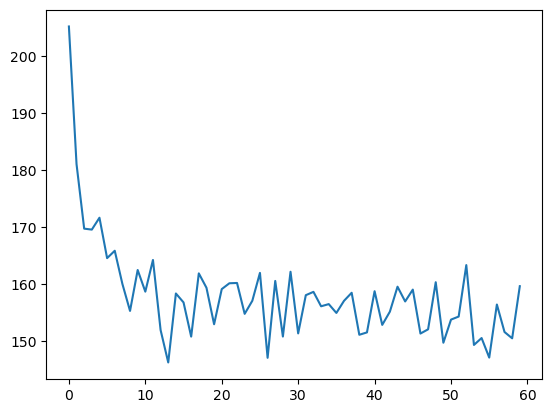

In [358]:
losses = []
for i in tqdm(range(epochs)):
    for (j,(xs,ys)) in enumerate(mnist_dset):
        out,mu,sigma = model(xs)
        loss = loss_fn(out,xs,mu,sigma)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if j % 300 == 0:
            print(f"loss {loss.item():.3f}")
            losses.append(loss.item())

plt.plot(losses)

In [366]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    vae.eval()
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    last = None
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            with torch.no_grad():
                z_sample = torch.tensor([[xi, yi]]).float()
                x_decoded = vae.decoder(z_sample)
                #if last is not None:
                    #assert torch.allclose(x_decoded[0],last)
                #last = x_decoded[0]
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("$z_0$")
    plt.ylabel("$z_1$")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

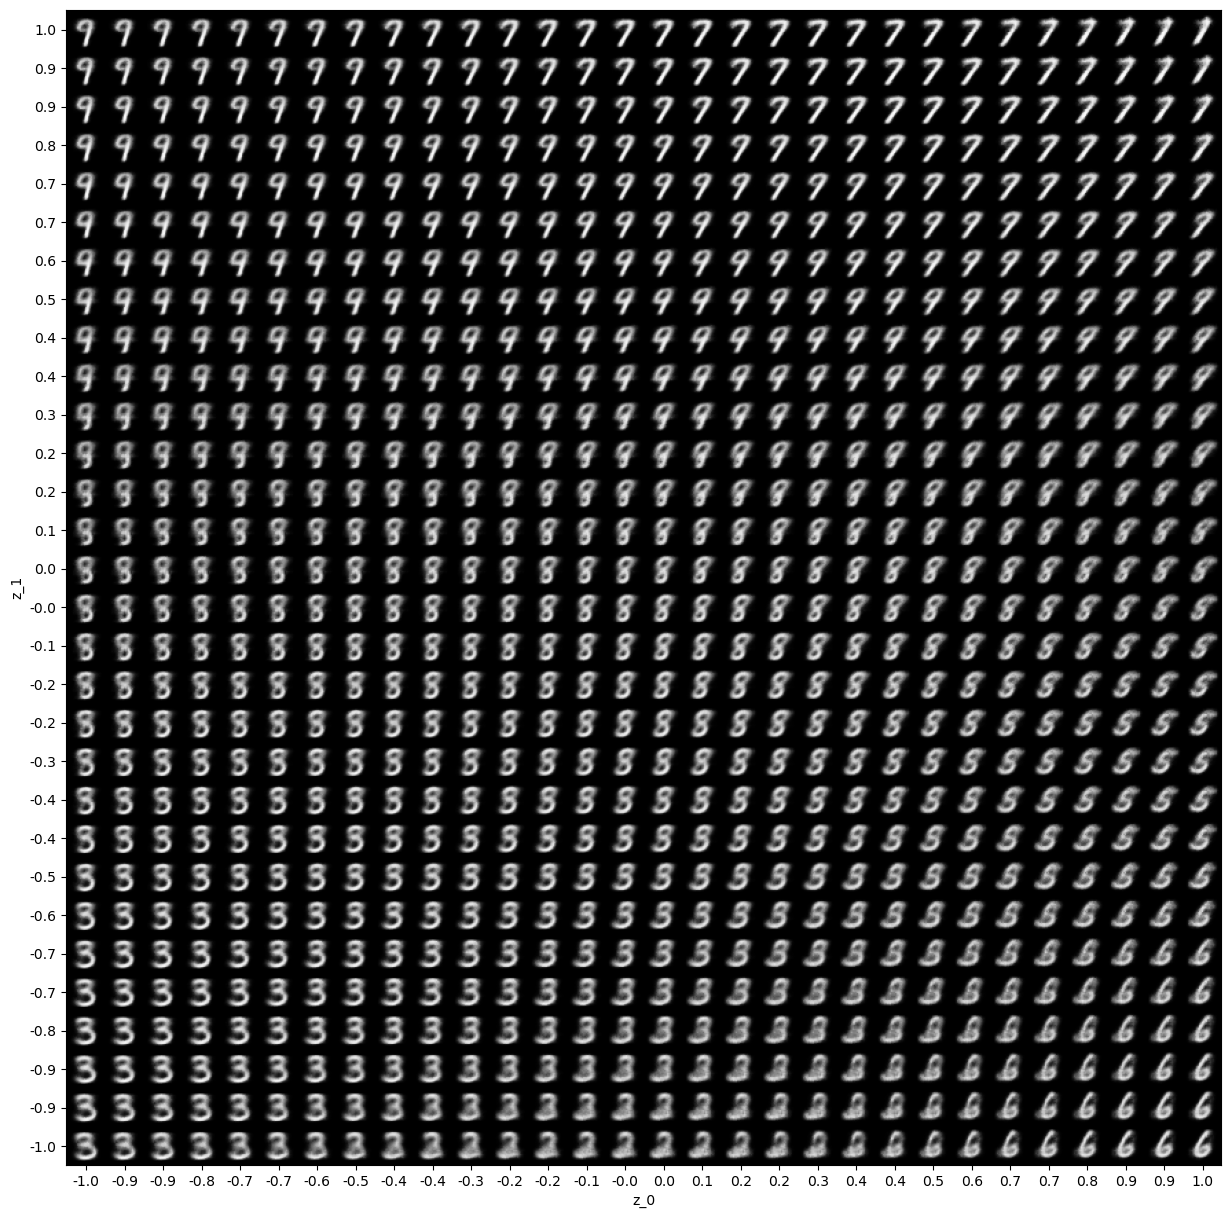

In [368]:
plot_latent_space(model)

In [278]:
model.eval()
original,label = mnist[0]
x = original.reshape(1,-1)
print(x.shape)
with torch.no_grad():
    enc = model.encoder(x)
    mu,sigma = model.mu_network(enc), model.std_network(enc)
    eps = torch.randn(latent_dim)
    z = mu + sigma*eps
    img = model.decode(z)
    img = img.reshape(28,28)
    plt.imshow(img)
    plt.figure()
    plt.imshow(original.squeeze())

torch.Size([1, 784])


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 784]